In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName('nyc_taxi_notebook_04') \
    .getOrCreate()

24/11/30 10:19:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [8]:
spark.sparkContext.uiWebUrl

'http://spark-medium.europe-southwest1-a.c.de-zoomcamp-jhigaki-course.internal:4040'

In [92]:
df_yellow = spark.read\
    .parquet(f'tmp-data/pq/yellow/*/*')\
    .withColumnRenamed('PULocationID', 'pickup_location_id')\
    .withColumnRenamed('tpep_pickup_datetime', 'pickup_datetime')
    #filter(F.col('pickup_datetime') < '2019-03-01 00:00:00') #yellow is too big, let's work with only two months

I addedd 

```python
 .filter(F.col('pickup_datetime') < '2019-03-01 00:00:00') #yellow is too big, let's work with only two months
```

so that processsing doesn't take that long, right now it takes 8min + to processs yellow dataset for 2019

## Zone

Let's add Zones for Borough
As we are going to partition the rides per Borough
and Borough coordinates

In [93]:
!wget https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv -O tmp-data/raw/taxi_zone_lookup.csv

--2024-11-29 17:20:08--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.111, 3.160.226.85, 3.160.226.161, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12331 (12K) [text/csv]
Saving to: ‘tmp-data/raw/taxi_zone_lookup.csv’

tmp-data/raw/taxi_z 100%[===================>]  12.04K  --.-KB/s    in 0s      

2024-11-29 17:20:08 (188 MB/s) - ‘tmp-data/raw/taxi_zone_lookup.csv’ saved [12331/12331]



In [94]:
df_zone = spark.read\
    .option("header", True)\
    .csv("tmp-data/raw/taxi_zone_lookup.csv")


from collections import namedtuple

# This should be obtained from a dataset 
# like something from: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

Coordinates = namedtuple('Coordinates', ['latitude', 'longitude'])
                                         
boroughs_coordinates = {
    "Bronx": Coordinates(40.837048, -73.865433),
    "Brooklyn": Coordinates(40.650002, -73.949997),
    "EWR": Coordinates(40.6895, -74.1745),
    "Manhattan": Coordinates(40.78343, -73.96625),
    "Queens": Coordinates(40.7282, -73.7949),
    "Staten Island": Coordinates(40.579021, -74.151535),
    "N/A": Coordinates(40.837048, -73.865433)
}
# Convert the dictionary to a DataFrame for easy joining
df_boroughs = spark.createDataFrame(\
    [(borough, coordinates) for borough, coordinates in boroughs_coordinates.items()],\
    ["borough", "coordinates"])
# Join the original DataFrame with the boroughs DataFrame
df_zone = df_zone.join(df_boroughs, on="Borough", how="left")
df_zone.show()


+-------------+----------+--------------------+------------+--------------------+
|      Borough|LocationID|                Zone|service_zone|         coordinates|
+-------------+----------+--------------------+------------+--------------------+
|       Queens|         2|         Jamaica Bay|   Boro Zone| {40.7282, -73.7949}|
|       Queens|         7|             Astoria|   Boro Zone| {40.7282, -73.7949}|
|       Queens|         8|        Astoria Park|   Boro Zone| {40.7282, -73.7949}|
|       Queens|         9|          Auburndale|   Boro Zone| {40.7282, -73.7949}|
|       Queens|        10|        Baisley Park|   Boro Zone| {40.7282, -73.7949}|
|       Queens|        15|Bay Terrace/Fort ...|   Boro Zone| {40.7282, -73.7949}|
|       Queens|        16|             Bayside|   Boro Zone| {40.7282, -73.7949}|
|       Queens|        19|           Bellerose|   Boro Zone| {40.7282, -73.7949}|
|          EWR|         1|      Newark Airport|         EWR| {40.6895, -74.1745}|
|     Brooklyn| 

In [95]:
df_yellow_zone = df_yellow.join(\
                    df_zone,\
                    df_yellow["pickup_location_id"] == df_zone["LocationID"], how="left" 
                    )\
                .withColumnRenamed('Borough', 'pickup_borough')\
                .withColumnRenamed('coordinates', 'pickup_borough_coordinates')


# Implement summarization based Borough

This is from  to [03_taxi_rides_spark](./03_taxi_rides_spark.ipynb)

In [96]:
def get_metrics_per_hour_pickup_location(df):
    return df.filter(\
        (F.col('pickup_datetime') >= '2019-01-01 00:00:00')\
        &(F.col('pickup_datetime') < '2020-01-01 00:00:00'))\
        .withColumn('pickup_hour', F.date_trunc('hour', 'pickup_datetime'))\
        .select('pickup_borough','pickup_hour', 'pickup_borough_coordinates', 'passenger_count', 'trip_distance','total_amount')\
        .groupBy('pickup_borough', 'pickup_hour')\
        .agg(\
            F.first('pickup_borough_coordinates').alias('pickup_borough_coordinates'),\
            F.sum('total_amount').alias('total_amount'),\
            F.sum('passenger_count').alias('passenger_count'),\
            F.sum('trip_distance').alias('trip_distance'),\
            F.count('*').alias('trip_count')\
        )\
        .orderBy('pickup_borough', 'pickup_hour')
    

In [97]:
df_yellow_metrics = get_metrics_per_hour_pickup_location(df_yellow_zone)\
    .withColumn('pickup_day', F.to_date('pickup_hour'))\
    .withColumn('service_type', F.lit('yelllow'))

In [98]:
partition_columns = ['pickup_borough', 'pickup_day']
df_yellow_metrics_repartitioned = df_yellow_metrics.repartition(*partition_columns)
df_yellow_metrics_repartitioned.show(10)

+--------------+-------------------+--------------------------+------------------+---------------+------------------+----------+----------+------------+
|pickup_borough|        pickup_hour|pickup_borough_coordinates|      total_amount|passenger_count|     trip_distance|trip_count|pickup_day|service_type|
+--------------+-------------------+--------------------------+------------------+---------------+------------------+----------+----------+------------+
|         Bronx|2019-02-27 00:00:00|      {40.837048, -73.8...|             229.1|            9.0|29.370000000000005|        10|2019-02-27|     yelllow|
|         Bronx|2019-02-27 01:00:00|      {40.837048, -73.8...|             64.15|            4.0|              16.2|         4|2019-02-27|     yelllow|
|         Bronx|2019-02-27 02:00:00|      {40.837048, -73.8...|               8.3|            3.0|1.8599999999999999|         3|2019-02-27|     yelllow|
|         Bronx|2019-02-27 03:00:00|      {40.837048, -73.8...|             80.26|

In [196]:

df_yellow_metrics_repartitioned.show(10)

+--------------+-------------------+--------------------------+------------------+---------------+------------------+----------+----------+------------+
|pickup_borough|        pickup_hour|pickup_borough_coordinates|      total_amount|passenger_count|     trip_distance|trip_count|pickup_day|service_type|
+--------------+-------------------+--------------------------+------------------+---------------+------------------+----------+----------+------------+
|         Bronx|2019-02-27 00:00:00|      {40.837048, -73.8...|             229.1|            9.0|29.370000000000005|        10|2019-02-27|     yelllow|
|         Bronx|2019-02-27 01:00:00|      {40.837048, -73.8...|             64.15|            4.0|              16.2|         4|2019-02-27|     yelllow|
|         Bronx|2019-02-27 02:00:00|      {40.837048, -73.8...|               8.3|            3.0|1.8599999999999999|         3|2019-02-27|     yelllow|
|         Bronx|2019-02-27 03:00:00|      {40.837048, -73.8...|             80.26|

In [99]:
a = lambda name, df : f"{name} partitions: {df.rdd.getNumPartitions()}"



df_yellow_metrics partitions: 1


df_yellow_metrics_repartitioned partitions: 1


Save them each to a parquet file

In [116]:
df_yellow_metrics_repartitioned.write\
    .partitionBy(*partition_columns)\
    .parquet(f'tmp-data/pq/reports/yellow/partition_by_day/')

In [132]:
!tree tmp-data/pq/reports/yellow/partition_by_day/

tmp-data/pq/reports/yellow/partition_by_day/
├── _SUCCESS
├── pickup_borough=Bronx
│   ├── pickup_day=2019-01-01
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-02
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-03
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-04
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-05
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-06
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-07
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-08
│   │   └── part-00000-1f346b32-2d68-4e94-9ce3-b754d8106c9d.c000.snappy.parquet
│   ├── pickup_day=2019-01-09
│   │  

### IMPORTANT: Reading partitioned directories

It is important to read specifying the `path`

Not the `path/*/*` wildcards 

Using wildcards may skip the directory structure that holds the partitioning information:

In [204]:
df_yellow_metrics_from_file = spark.read\
    .parquet(f'tmp-data/pq/reports/yellow/partition_by_day/')

print(a("df_yellow_metrics_repartitioned", df_yellow_metrics_from_file))

df_yellow_metrics_repartitioned partitions: 92


In [205]:
df_yellow_metrics_from_file_2.show(5)

+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+
|        pickup_hour|pickup_borough_coordinates|      total_amount|passenger_count|     trip_distance|trip_count|service_type|pickup_borough|pickup_day|
+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+
|2019-02-18 01:00:00|      {40.78343, -73.96...| 48157.67999999936|         4648.0| 8218.600000000004|      2910|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 03:00:00|      {40.78343, -73.96...| 26411.45999999986|         2203.0| 4808.209999999999|      1438|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 04:00:00|      {40.78343, -73.96...|29893.579999999813|         2055.0| 6207.290000000001|      1330|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 07:00:00|      {40.78343, -73.96...| 64936.24999999913|         5938.0

## Count rcords and partitions

It gives us
* 59432 records
* 1 partition of metrics on df where it was calculated
* 1 partition of metrics on df where it was repartition by columns
* 92 partitions of metrics on df when read from disc

In [ ]:
def count_per_partition(partition):  
    i = 0
    for row in partition:
        i += 1

    return [i]


In [127]:
df_yellow_metrics_from_file.rdd\
    .mapPartitions(count_per_partition)\
    .collect()

[768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 767,
 768,
 768,
 768,
 767,
 767,
 768,
 768,
 768,
 768,
 768,
 767,
 768,
 767,
 768,
 768,
 768,
 765,
 767,
 767,
 768,
 767,
 767,
 766,
 764,
 760,
 763,
 761,
 760,
 757,
 755,
 750,
 740,
 741,
 722,
 717,
 726,
 753,
 764,
 763,
 764,
 764,
 763,
 758,
 768,
 767,
 768,
 763,
 636,
 495,
 462,
 439,
 422,
 421,
 395,
 376,
 355,
 337,
 318,
 308,
 297,
 283,
 272,
 251,
 245,
 232,
 219,
 212,
 194,
 185,
 161,
 28]

In [126]:
sum([768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 768,
 767,
 768,
 768,
 768,
 767,
 767,
 768,
 768,
 768,
 768,
 768,
 767,
 768,
 767,
 768,
 768,
 768,
 765,
 767,
 767,
 768,
 767,
 767,
 766,
 764,
 760,
 763,
 761,
 760,
 757,
 755,
 750,
 740,
 741,
 722,
 717,
 726,
 753,
 764,
 763,
 764,
 764,
 763,
 758,
 768,
 767,
 768,
 763,
 636,
 495,
 462,
 439,
 422,
 421,
 395,
 376,
 355,
 337,
 318,
 308,
 297,
 283,
 272,
 251,
 245,
 232,
 219,
 212,
 194,
 185,
 161,
 28])

59432

In [122]:
df_yellow_metrics.count()

59432

In [128]:
df_yellow_metrics_repartitioned.count()

In [129]:
df_yellow_metrics_from_file.count()

59432

In [131]:
print(a("df_yellow_metrics", df_yellow_metrics))
print(a("df_yellow_metrics_repartitioned", df_yellow_metrics_repartitioned))
print(a("df_yellow_metrics_from_file", df_yellow_metrics_from_file))


df_yellow_metrics partitions: 1
df_yellow_metrics_repartitioned partitions: 1
df_yellow_metrics_from_file partitions: 92


## Processsing per Partition 

*Use mapPartitions when the transformation requires setup or teardown of resources (like database connections) that are expensive to initialize for each element but can be shared across elements within the same partition.*

Lets's say we need to calculate the weather info

My plan was to use the partitioning by DAY / BOROUGH to query the weather API  ONCE per partition
But I cannot guarantee that each time I processs a partition, I have a single BOROUGH / DAY occurrence


****WHY???****

In [213]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import os
import json
import hashlib

# Function to handle retries
def get_with_retries(url, params, retries=5, backoff_factor=0.2):
    for i in range(retries):
        response = requests.get(url, params=params)
        if response.status_code == 200:
            return response.json()
        else:
            time.sleep(backoff_factor * (2 ** i))  # Exponential backoff
    raise Exception(f"Failed to fetch data after {retries} retries")

# Function to generate a unique cache key based on parameters
def generate_cache_key(url, params):
    param_string = url + json.dumps(params, sort_keys=True)
    return hashlib.md5(param_string.encode('utf-8')).hexdigest()


# Function to fetch data and cache it to disk
def fetch_and_cache_data(url, params, cache_path='tmp-data/json/cache', force_api_call=False):
    # Generate a unique cache key 
    cache_key = generate_cache_key(url, params) 
    cache_file = os.path.join(cache_path, f"{cache_key}.json")
    # Check if cache file exists
    if os.path.exists(cache_file) and not force_api_call:
        with open(cache_file, 'r') as file:
            data = json.load(file)
        print("Loaded data from cache")
    else:
        # Fetch data from API
        data = get_with_retries(url, params)        
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        with open(cache_file, 'w') as file:
            json.dump(data, file)
        print("Fetched data from API and cached it")
    return data

def get_weather_data(latitude, longitude, day_datetime):
    # Set up the parameters for the API request
    beginning_of_year = day_datetime.replace(month=1, day=1) 
    end_of_year = day_datetime.replace(month=12, day=31) 
    beginning_of_year_str = beginning_of_year.strftime('%Y-%m-%d') 
    end_of_year_str = end_of_year.strftime('%Y-%m-%d')
    url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        # I will keep the start and end dates hardcoded 
        # Because It is cheap to request data for the entire year
        # this way, I maximize cache time 
        # If I execute the API for the exact day, I will hit API limits
        "start_date": "2019-01-01",
        #"start_date": beginning_of_year_str,
        "end_date": "2019-12-31",        
        #"end_date": end_of_year_str,
        "hourly": ["temperature_2m", "cloud_cover"],
        "timezone": "GMT"
    }

    # Make the API request with retries
    data = fetch_and_cache_data(url, params)

    # Extract and process the data
    hourly = data['hourly']
    time_values = pd.date_range(
        start=pd.to_datetime(hourly['time'][0]),
        end=pd.to_datetime(hourly['time'][-1]) + timedelta(hours=1),
        freq='h',
        inclusive='left'
    )

    hourly_data = {
        "date_hour": [datetime.strptime(time, "%Y-%m-%dT%H:%M") for time in data['hourly']['time']],
        "temperature_2m": hourly['temperature_2m'],
        "cloud_cover": hourly['cloud_cover']
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)
    return hourly_dataframe
    



In [152]:
weather_data = get_weather_data(40.7834, -73.9663)
weather_data

Loaded data from cache


,date_hour,temperature_2m,cloud_cover
0,2019-01-01 00:00:00,5.5,100
1,2019-01-01 01:00:00,5.6,100
2,2019-01-01 02:00:00,6.2,100
3,2019-01-01 03:00:00,6.6,100
4,2019-01-01 04:00:00,7.0,100
...,...,...,...
8755,2019-12-31 19:00:00,6.4,0
8756,2019-12-31 20:00:00,6.6,1
8757,2019-12-31 21:00:00,6.1,11
8758,2019-12-31 22:00:00,4.8,4


In [206]:
df_yellow_metrics_from_file_sample_4 = df_yellow_metrics_from_file.limit(4)

In [207]:
df_yellow_metrics_from_file_sample_4.show()

+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+
|        pickup_hour|pickup_borough_coordinates|      total_amount|passenger_count|     trip_distance|trip_count|service_type|pickup_borough|pickup_day|
+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+
|2019-02-18 01:00:00|      {40.78343, -73.96...| 48157.67999999936|         4648.0| 8218.600000000004|      2910|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 03:00:00|      {40.78343, -73.96...| 26411.45999999986|         2203.0| 4808.209999999999|      1438|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 04:00:00|      {40.78343, -73.96...|29893.579999999813|         2055.0| 6207.290000000001|      1330|     yelllow|     Manhattan|2019-02-18|
|2019-02-18 07:00:00|      {40.78343, -73.96...| 64936.24999999913|         5938.0

In [300]:
import numpy as  np
# Function to process each partition
def process_partition(iterator):
    # I was hoping I could invoke get weather data here    
    print("here")
    for row in iterator:        
        #latitude, longitude = row['pickup_borough_coordinates'] if row['pickup_borough_coordinates']  else 0,0
        latitude = float(row['pickup_borough_coordinates'][0])
        longitude = float(row['pickup_borough_coordinates'][1])
        weather_data = get_weather_data(latitude, longitude, row['pickup_day'])
        weather_rows = weather_data.loc[weather_data['date_hour'] == row['pickup_hour']]
        temperature_2m = 0
        cloud_cover = 0
        if not weather_rows.empty:                        
            temperature_2m = float(weather_rows.iloc[0]["temperature_2m"])
            cloud_cover = float(weather_rows.iloc[0]["cloud_cover"])
    #print((latitude, longitude, temperature_2, cloud_cover))
        #yield (latitude, longitude, )
        yield (row['pickup_hour'], 
                row['pickup_borough_coordinates'], 
                row['total_amount'],
                row['passenger_count'], 
                row['trip_distance'], 
                row['trip_count'], 
                row['service_type'],
                row['pickup_borough'],
                row['pickup_day'],
                temperature_2m, 
                cloud_cover)

        

In [298]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, TimestampType, DateType

# Define the schema
schema = StructType([    
    StructField("pickup_hour", TimestampType(), nullable=True),
    StructField("pickup_borough_coordinates", StructType([
        StructField("latitude", FloatType(), nullable=True),
        StructField("longitude", FloatType(), nullable=True)
    ]), nullable=True),
    StructField("total_amount", DoubleType(), nullable=True),
    StructField("passenger_count", DoubleType(), nullable=True),
    StructField("trip_distance", DoubleType(), nullable=True),
    StructField("trip_count", LongType(), nullable=True),
    StructField("service_type", StringType(), nullable=True),
    StructField("pickup_borough", StringType(), nullable=True),
    StructField("pickup_day", DateType(), nullable=True),
    StructField("temperature_2m", FloatType(), nullable=True), 
    StructField("cloud_cover", FloatType(), nullable=True)
])



In [292]:
df_yellow_metrics_from_file_sample_4.printSchema()

root
 |-- pickup_hour: timestamp (nullable = true)
 |-- pickup_borough_coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_count: long (nullable = true)
 |-- service_type: string (nullable = true)
 |-- pickup_borough: string (nullable = true)
 |-- pickup_day: date (nullable = true)



In [301]:

df_yellow_metrics_from_file_sample_4.rdd.mapPartitions(process_partition).toDF(schema).show()

here
Loaded data from cache
Loaded data from cache                                              (0 + 1) / 1]
Loaded data from cache
Loaded data from cache


+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+--------------+-----------+
|        pickup_hour|pickup_borough_coordinates|      total_amount|passenger_count|     trip_distance|trip_count|service_type|pickup_borough|pickup_day|temperature_2m|cloud_cover|
+-------------------+--------------------------+------------------+---------------+------------------+----------+------------+--------------+----------+--------------+-----------+
|2019-02-18 01:00:00|      {40.78343, -73.96...| 48157.67999999936|         4648.0| 8218.600000000004|      2910|     yelllow|     Manhattan|2019-02-18|           0.4|      100.0|
|2019-02-18 03:00:00|      {40.78343, -73.96...| 26411.45999999986|         2203.0| 4808.209999999999|      1438|     yelllow|     Manhattan|2019-02-18|           0.4|      100.0|
|2019-02-18 04:00:00|      {40.78343, -73.96...|29893.579999999813|         2055.0| 6207.29000000000

In [309]:
df_yellow_metrics_from_file.rdd.mapPartitions(process_partition).toDF(schema)\
    .withColumn("latitude", F.col("pickup_borough_coordinates.latitude"))\
    .withColumn("longitude", F.col("pickup_borough_coordinates.longitude"))\
    .drop("pickup_borough_coordinates")\
    .write\
    .csv('tmp-data/csv/reports/yellow/2019-temp-by-hour.csv', header=True)

herege 618:>                                                       (0 + 2) / 92]
here
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from cache
Loaded data from 

Py4JJavaError: An error occurred while calling o2991.csv.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 55 in stage 618.0 failed 1 times, most recent failure: Lost task 55.0 in stage 618.0 (TID 16837) (spark-medium.europe-southwest1-a.c.de-zoomcamp-jhigaki-course.internal executor driver): org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/spark_jhigaki_gcp/tmp-data/csv/reports/yellow/2019-temp-by-hour.csv.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:788)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:891)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:891)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14913/2891228974.py", line 8, in process_partition
TypeError: 'NoneType' object is not subscriptable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:91)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1563)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2790)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2726)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2725)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2725)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1211)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1211)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2989)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2928)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2917)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:976)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2258)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeWrite$4(FileFormatWriter.scala:307)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.writeAndCommit(FileFormatWriter.scala:271)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeWrite(FileFormatWriter.scala:304)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.write(FileFormatWriter.scala:190)
	at org.apache.spark.sql.execution.datasources.InsertIntoHadoopFsRelationCommand.run(InsertIntoHadoopFsRelationCommand.scala:190)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult$lzycompute(commands.scala:113)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.sideEffectResult(commands.scala:111)
	at org.apache.spark.sql.execution.command.DataWritingCommandExec.executeCollect(commands.scala:125)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.$anonfun$applyOrElse$1(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:118)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:195)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:103)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:827)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:65)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:94)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:104)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:512)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:31)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:488)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:94)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:81)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:79)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:133)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:856)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:387)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:360)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:239)
	at org.apache.spark.sql.DataFrameWriter.csv(DataFrameWriter.scala:847)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: [TASK_WRITE_FAILED] Task failed while writing rows to file:/home/spark_jhigaki_gcp/tmp-data/csv/reports/yellow/2019-temp-by-hour.csv.
	at org.apache.spark.sql.errors.QueryExecutionErrors$.taskFailedWhileWritingRowsError(QueryExecutionErrors.scala:788)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:420)
	at org.apache.spark.sql.execution.datasources.WriteFilesExec.$anonfun$doExecuteWrite$1(WriteFiles.scala:100)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2(RDD.scala:891)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsInternal$2$adapted(RDD.scala:891)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 830, in main
    process()
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/worker.py", line 822, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/spark_jhigaki_gcp/spark/spark-3.4.4-bin-hadoop3/python/lib/pyspark.zip/pyspark/serializers.py", line 274, in dump_stream
    vs = list(itertools.islice(iterator, batch))
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_14913/2891228974.py", line 8, in process_partition
TypeError: 'NoneType' object is not subscriptable

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:561)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:767)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at org.apache.spark.sql.execution.datasources.FileFormatDataWriter.writeWithIterator(FileFormatDataWriter.scala:91)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.$anonfun$executeTask$1(FileFormatWriter.scala:403)
	at org.apache.spark.util.Utils$.tryWithSafeFinallyAndFailureCallbacks(Utils.scala:1563)
	at org.apache.spark.sql.execution.datasources.FileFormatWriter$.executeTask(FileFormatWriter.scala:410)
	... 15 more


Loaded data from cache


In [ ]:
scp de-zoomcamp-spark-medium:/home/spark_jhigaki_gcp/tmp-data/csv/reports/yellow/2019-temp-by-hour.csv  /workspaces/data-engineering-zoomcamp/05-batch/2019-temp-by-hour.csv


process_partition interattive approach doesn't work

	28 min 34/92 partitions

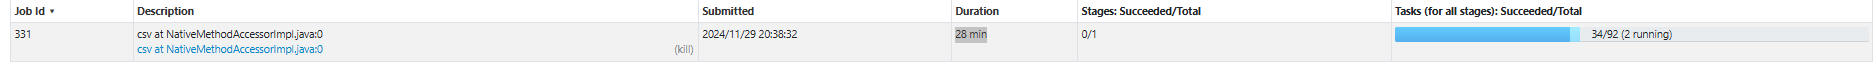



Another approach
at the partition function: 
- get Boroughs, day
- accumulate get weather data
- join 


Or, instead f writing csv, save to bigquery or save to GCS